# Model

In [0]:
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from tqdm.notebook import tqdm as tqdm_n
import torch
import time as t
import matplotlib.pyplot as plt

In [0]:
class encoder_RF(object):
  def __init__(self,n_estimators,max_depth,supervised):
    if supervised:
      self.model = RandomForestClassifier(n_estimators=n_estimators,max_depth=50,random_state=0)
    else:
      self.model = RandomTreesEmbedding(n_estimators=n_estimators,max_depth=50,random_state=0)
  def fit(self,X,y=None):
    if y is None:
      self.model.fit(X)
    else:
      self.model.fit(X,y)
  def predict(self,X):
    pred = self.model.apply(X)
    return pred
  def fit_predict(self,X):
    self.fit(X)
    return self.predict(X)

class decoder_RF(object):
  def randomly_drop_trees(self,input_range,n):
    output_range = input_range.copy()
    np.random.seed(0)
    for i in range(len(input_range)-n):
      index = np.random.randint(0,len(output_range))
      output_range = np.delete(output_range,index)
    return output_range
  def __init__(self,n_estimators):
    self.n_trees = n_estimators
  def calculate_rules(self,target):
    trees = self.trees
    X = self.X
    init = [[[-np.infty,np.infty] for j in range(self.n_features)] for i in range(self.n_trees)]
    #for each tree generate rules for each leave
    for i in self.trees_range:
      #tree params
      feature = trees[i].tree_.feature
      threshold = trees[i].tree_.threshold
      #objects params
      index = self.indexs[:,i]
      #index = trees[i].apply(X)
      #for each leave generate rule
      leave = target[i]
      #let's choose the object from this leave
      chosen_index = np.where(leave == index)[0][0]
      object_path = trees[i].decision_path(X[chosen_index][np.newaxis,:]).toarray()[0]
      object_features = X[chosen_index]
      for _,node in enumerate(np.where(object_path == 1)[0]):
        node_feature = feature[node]
        node_threshold = threshold[node]
        node_val = object_features[node_feature]
        if node_val <= node_threshold:
          init[i][node_feature][1] = np.min([init[i][node_feature][1],node_threshold])
        else:
          init[i][node_feature][0] = np.max([init[i][node_feature][0],node_threshold])
    return init  
  def fit(self,encoder,X):
    self.trees = encoder.estimators_
    self.X = X
    self.median_X = np.median(X,axis=0)
    self.n_features = X.shape[1]
    self.indexs = encoder.apply(X)
  
  def compress_set(self,set_rules):
    a = np.array(set_rules)
    return np.vstack([np.max(a[:,:,0],axis=0),np.min(a[:,:,1],axis=0)]).T
        

  def predict(self,X,dropout):
    if dropout is None:
      self.trees_range = np.arange(self.n_trees)
    else:
      number = self.n_trees - int(self.n_trees*dropout)
      self.trees_range = self.randomly_drop_trees(np.arange(self.n_trees),number)
    result = np.empty((X.shape[0],self.n_features))
    for i in tqdm_n(range(X.shape[0])):
      obj = X[i]
      set_rules = self.calculate_rules(obj)
      rule = self.compress_set(set_rules)
      for j,unit in enumerate(rule):
        if unit[0] < 0 and unit[1] > 255:
          result[i,j] = self.median_X[j]
        elif unit[0] < 0 and unit[1] <= 255:
          result[i,j] = unit[1]
        elif unit[1] > 255 and unit[0] >= 0 :
          result[i,j] = unit[0]
        else:
          result[i,j] = np.mean(unit)
    return result


class AutoEncoderRF(object):
  def __init__(self,size=500,max_depth=50,supervised=False):
    self.encoder = encoder_RF(size,max_depth,supervised)
    self.decoder = decoder_RF(size)
  
  def __call__(self,X):
    return self.predict(X)
  
  def fit(self,X,y=None):
    if y is None:
      self.encoder.fit(X)
      self.decoder.fit(self.encoder.model,X)
    else:
      self.encoder.fit(X,y)
      self.decoder.fit(self.encoder.model,X)
  
  def predict(self,X,dropout=None):
    pred = self.decoder.predict(self.encoder.predict(X),dropout)
    return pred
  
  def fit_predict(self,X):
    self.fit(X)
    return self.predict(X)

In [0]:
def mse(x,y):
  x_torch = torch.Tensor(x)
  y_torch = torch.Tensor(y)
  criterion = torch.nn.MSELoss()
  return criterion(x_torch,y_torch).detach().numpy()

# Test model on MNIST with different parameters

In [11]:
from keras.datasets import mnist

(x_train, y_train_mnist), (x_test, y_test_mnist) = mnist.load_data()
x_train_mnist = x_train.reshape((x_train.shape[0], -1))
x_test_mnist = x_test.reshape((x_test.shape[0], -1))
print("[mnist] x_train.shape={}, y_train.shape={}".format(x_train_mnist.shape, y_train_mnist.shape))
print("[mnist] x_test.shape={}, y_test.shape={}".format(x_test_mnist.shape, y_test_mnist.shape))
test_size = 1000
encoded_mnist = [0,0,0,0]
time_mnist = [0,0,0,0]
params = {'size':[500,1000,500,1000],'supervised':[True,True,False,False]}
for i in range(3,-1,-1):
  #supervised
  size = params['size'][i]
  supervised = params['supervised'][i]
  print("========================================================================")
  print(f"Autoencoder by forest with n_estimators:{size} and "+"un"*(1-int(supervised))+"supervised learning")
  encoder_mnist = AutoEncoderRF(size=size,supervised=supervised)
  if supervised:
    t0 = t.time()
    encoder_mnist.fit(x_train_mnist,y_train_mnist)
    t1 = t.time()
    time_mnist[i] = t1-t0
  else:
    t0 = t.time()
    encoder_mnist.fit(x_train_mnist)
    t1 = t.time()
    time_mnist[i] = t1-t0
  encoded_mnist[i] = encoder_mnist.predict(x_test_mnist[:test_size])
  mse_ = mse(x_test_mnist[:test_size].reshape(test_size,1,28,28),encoded_mnist[i][:test_size].reshape(test_size,1,28,28))
  encoded_mnist[i] = encoded_mnist[i][:10]
  print(f"MSE:{mse_}, Time for fit:{time_mnist[i]}")

[mnist] x_train.shape=(60000, 784), y_train.shape=(60000,)
[mnist] x_test.shape=(10000, 784), y_test.shape=(10000,)
Autoencoder by forest with n_estimators:1000 and unsupervised learning



MSE:38.79048538208008, Time for fit:217.6699800491333
Autoencoder by forest with n_estimators:500 and unsupervised learning



MSE:168.3861541748047, Time for fit:108.25233459472656
Autoencoder by forest with n_estimators:1000 and supervised learning



MSE:982.054931640625, Time for fit:574.2414877414703
Autoencoder by forest with n_estimators:500 and supervised learning



MSE:1809.98388671875, Time for fit:289.7679126262665


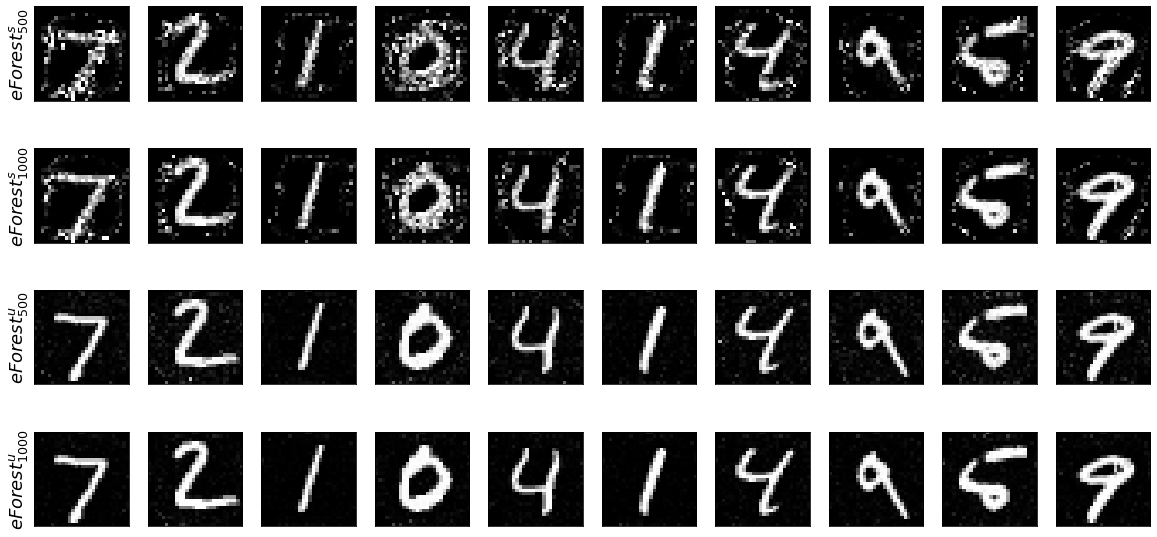

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=10, nrows=len(encoded_mnist), figsize=(20, 2.5*len(encoded_mnist)))
for j in range(len(encoded_mnist)):
  for i in range(10):
    rec = encoded_mnist[j][i].astype(int)
    ax[j, i].imshow(rec.reshape(28,28),cmap='gray')
    ax[j,i].get_xaxis().set_ticks([])
    ax[j,i].get_yaxis().set_ticks([])
  s = "s" if params["supervised"][j] else "u"
  n = params["size"][j]
  ax[j,0].set_ylabel(f"$eForest_{{{n}}}^{{{s}}}$",fontsize=18)

# Test model on CIFAR-10 with different parameters

In [4]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_cifar = x_train.reshape((x_train.shape[0], -1, 3))
x_test_cifar = x_test.reshape((x_test.shape[0], -1, 3))
y_train_cifar = y_train.reshape(-1)
y_test_cifar = y_test.reshape(-1)
print("[cifar] x_train.shape={}, y_train.shape={}".format(x_train_cifar.shape, y_train_cifar.shape))
print("[cifar] x_test.shape={}, y_test.shape={}".format(x_test_cifar.shape, y_test_cifar.shape))

test_size=1000
encoded_cifar = [0,0,0,0]
time_cifar = [0,0,0,0]
params = {'size':[500,1000,500,1000],'supervised':[True,True,False,False]}
for i in range(3,-1,-1):
  #supervised
  size = params['size'][i]
  supervised = params['supervised'][i]
  print("========================================================================")
  print(f"Autoencoder by forest with n_estimators:{size} and "+"un"*(1-int(supervised))+"supervised learning")
  if supervised:
    encoder_cifar = AutoEncoderRF(size=size,supervised=supervised)
    t0 = t.time()
    encoder_cifar.fit(x_train_cifar.reshape(x_train_cifar.shape[0],32*32*3),y_train_cifar)
    time_cifar[i] += t.time()-t0
    encoded_cifar[i] = encoder_cifar.predict(x_test_cifar[:test_size].reshape(test_size,32*32*3))
  else:
    encoder_cifar = AutoEncoderRF(size=size,supervised=supervised)
    t0 = t.time()
    encoder_cifar.fit(x_train_cifar.reshape(x_train_cifar.shape[0],32*32*3))
    time_cifar[i] += t.time()-t0
    encoded_cifar[i] = encoder_cifar.predict(x_test_cifar[:test_size].reshape(test_size,32*32*3))
    
  mse_ = mse(x_test_cifar[:test_size].reshape(test_size,1,32,32,3),encoded_cifar[i][:test_size].reshape(test_size,1,32,32,3))
  encoded_cifar[i] = encoded_cifar[i][:10]
  print(f"MSE:{mse_}, Time for fit:{time_cifar[i]}")

Using TensorFlow backend.


170500096/170498071 [==============================] - 11s 0us/step
[cifar] x_train.shape=(50000, 1024, 3), y_train.shape=(50000,)
[cifar] x_test.shape=(10000, 1024, 3), y_test.shape=(10000,)
Autoencoder by forest with n_estimators:1000 and unsupervised learning



MSE:520.9684448242188, Time for fit:171.95740938186646
Autoencoder by forest with n_estimators:500 and unsupervised learning



MSE:1922.4951171875, Time for fit:89.9382073879242
Autoencoder by forest with n_estimators:1000 and supervised learning



MSE:1848.8900146484375, Time for fit:2333.1519000530243
Autoencoder by forest with n_estimators:500 and supervised learning



MSE:3108.182373046875, Time for fit:1179.9011228084564


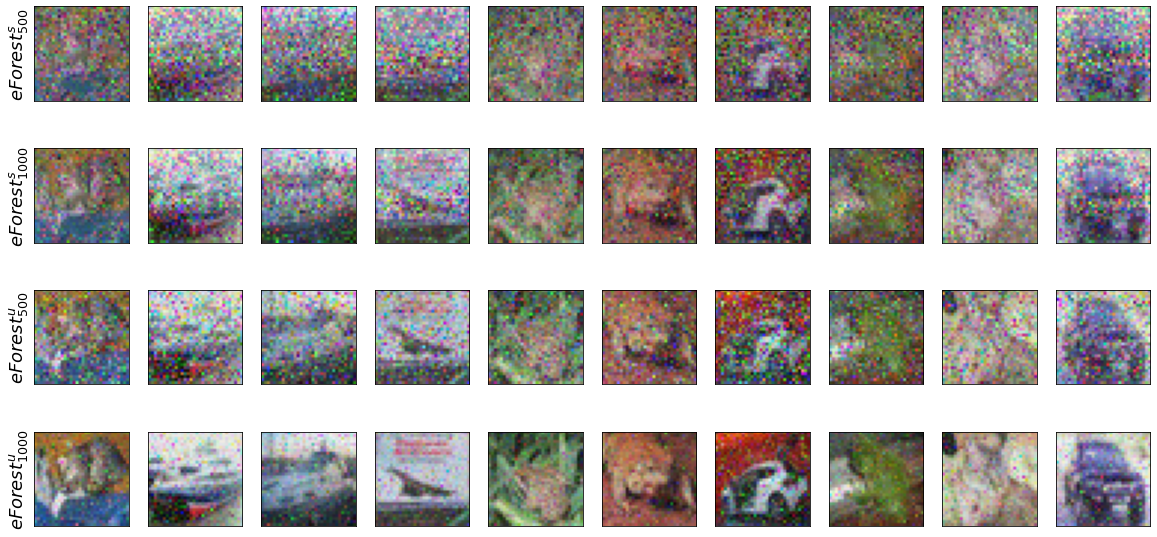

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=10, nrows=len(encoded_cifar), figsize=(20, 2.5*len(encoded_cifar)))
for j in range(len(encoded_cifar)):
  for i in range(10):
    rec = encoded_cifar[j][i].astype(int)
    ax[j, i].imshow(rec.reshape(32,32,3))
    ax[j,i].get_xaxis().set_ticks([])
    ax[j,i].get_yaxis().set_ticks([])
  s = "s" if params["supervised"][j] else "u"
  n = params["size"][j]
  ax[j,0].set_ylabel(f"$eForest_{{{n}}}^{{{s}}}$",fontsize=18)

# Damage tolerable for MNIST

In [0]:
from keras.datasets import mnist

(x_train, y_train_mnist), (x_test, y_test_mnist) = mnist.load_data()
x_train_mnist = x_train.reshape((x_train.shape[0], -1))
x_test_mnist = x_test.reshape((x_test.shape[0], -1))
print("[mnist] x_train.shape={}, y_train.shape={}".format(x_train_mnist.shape, y_train_mnist.shape))
print("[mnist] x_test.shape={}, y_test.shape={}".format(x_test_mnist.shape, y_test_mnist.shape))
test_size = 1000
encoded_mnist = [0,0,0,0,0,0,0,0]
params = {'size':[1000,1000,1000,1000,1000,1000,1000,1000],'supervised':[True,True,True,True,False,False,False,False],'dropout':[None,0.25,0.5,0.75,None,0.25,0.5,0.75]}
encoder_mnist_s = AutoEncoderRF(size=1000,supervised=True)
encoder_mnist_s.fit(x_train_mnist.reshape(x_train_mnist.shape[0],28*28),y_train_mnist)
encoder_mnist_u = AutoEncoderRF(size=1000,supervised=False)
encoder_mnist_u.fit(x_train_mnist.reshape(x_train_mnist.shape[0],28*28))
for i in range(8):
  #supervised
  size = params['size'][i]
  supervised = params['supervised'][i]
  dropout = params['dropout'][i]
  print("========================================================================")
  print(f"Autoencoder by forest with dropout:{0 if dropout is None else int(dropout*100)}% and "+"un"*(1-int(supervised))+"supervised learning")
  if supervised:
    encoded_mnist[i] = encoder_mnist_s.predict(x_test_mnist[:test_size],dropout)
  else:
    encoded_mnist[i] = encoder_mnist_u.predict(x_test_mnist[:test_size],dropout)
  mse_ = mse(x_test_mnist[:test_size].reshape(test_size,1,28,28),encoded_mnist[i][:test_size].reshape(test_size,1,28,28))
  encoded_mnist[i] = encoded_mnist[i][:10]
  print(f"MSE:{mse_}")

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=10, nrows=5, figsize=(20, 2.5*5))
for i in range(10):
  rec = x_test_mnist[i].astype(int)
  ax[0, i].imshow(rec.reshape(28,28),cmap='gray')
  ax[0,i].get_xaxis().set_ticks([])
  ax[0,i].get_yaxis().set_ticks([])
ax[0,0].set_ylabel(f"Original",fontsize=18)

for j in range(4):
  for i in range(10):
    rec = encoded_mnist[j][i].astype(int)
    dropout = params['dropout'][j]
    ax[j+1, i].imshow(rec.reshape(28,28),cmap='gray')
    ax[j+1,i].get_xaxis().set_ticks([])
    ax[j+1,i].get_yaxis().set_ticks([])
  s = "s" if params["supervised"][j] else "u"
  n = params["size"][j]
  ax[j+1,0].set_ylabel(f"Drop {0 if dropout is None else int(dropout*100)}%",fontsize=18)

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=10, nrows=5, figsize=(20, 2.5*5))
for i in range(10):
  rec = x_test_mnist[i].astype(int)
  ax[0, i].imshow(rec.reshape(28,28),cmap='gray')
  ax[0,i].get_xaxis().set_ticks([])
  ax[0,i].get_yaxis().set_ticks([])
ax[0,0].set_ylabel(f"Original",fontsize=18)

for j in range(4,8):
  for i in range(10):
    rec = encoded_mnist[j][i].astype(int)
    dropout = params['dropout'][j]
    ax[j-4+1, i].imshow(rec.reshape(28,28),cmap='gray')
    ax[j-4+1,i].get_xaxis().set_ticks([])
    ax[j-4+1,i].get_yaxis().set_ticks([])
  s = "s" if params["supervised"][j] else "u"
  n = params["size"][j]
  ax[j-4+1,0].set_ylabel(f"Drop {0 if dropout is None else int(dropout*100)}%",fontsize=18)

# Damage tolerable for CIFAR-10


In [0]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_cifar = x_train.reshape((x_train.shape[0], -1, 3))
x_test_cifar = x_test.reshape((x_test.shape[0], -1, 3))
y_train_cifar = y_train.reshape(-1)
y_test_cifar = y_test.reshape(-1)
print("[cifar] x_train.shape={}, y_train.shape={}".format(x_train_cifar.shape, y_train_cifar.shape))
print("[cifar] x_test.shape={}, y_test.shape={}".format(x_test_cifar.shape, y_test_cifar.shape))

test_size=1000
encoded_cifar = [0,0,0,0,0,0,0,0]
params = {'size':[1000,1000,1000,1000,1000,1000,1000,1000],'supervised':[True,True,True,True,False,False,False,False],'dropout':[None,0.25,0.5,0.75,None,0.25,0.5,0.75]}
encoder_cifar_s = AutoEncoderRF(size=1000,supervised=True)
encoder_cifar_s.fit(x_train_cifar.reshape(x_train_cifar.shape[0],32*32*3),y_train_cifar)
encoder_cifar_u = AutoEncoderRF(size=1000,supervised=False)
encoder_cifar_u.fit(x_train_cifar.reshape(x_train_cifar.shape[0],32*32*3))
for i in range(8):
  #supervised
  size = params['size'][i]
  supervised = params['supervised'][i]
  dropout = params['dropout'][i]
  print("========================================================================")
  print(f"Autoencoder by forest with dropout:{0 if dropout is None else int(dropout*100)}% and "+"un"*(1-int(supervised))+"supervised learning")
  if supervised:
    encoded_cifar[i] = encoder_cifar_s.predict(x_test_cifar[:test_size].reshape(test_size,32*32*3),dropout)

  else:

    encoded_cifar[i] = encoder_cifar_u.predict(x_test_cifar[:test_size].reshape(test_size,32*32*3),dropout)

  mse_ = mse(x_test_cifar[:test_size].reshape(test_size,1,32,32,3),encoded_cifar[i][:test_size].reshape(test_size,1,32,32,3))
  encoded_cifar[i] = encoded_cifar[i][:10]
  print(f"MSE:{mse_}")

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=10, nrows=5, figsize=(20, 2.5*5))
for i in range(10):
  rec = x_test_cifar[i]
  ax[0, i].imshow(rec.reshape(32,32,3))
  ax[0,i].get_xaxis().set_ticks([])
  ax[0,i].get_yaxis().set_ticks([])
ax[0,0].set_ylabel(f"Original",fontsize=18)

for j in range(4):
  for i in range(10):
    rec = encoded_cifar[j][i]
    dropout = params['dropout'][j]
    ax[j+1, i].imshow(rec.reshape(32,32,3))
    ax[j+1,i].get_xaxis().set_ticks([])
    ax[j+1,i].get_yaxis().set_ticks([])
  s = "s" if params["supervised"][j] else "u"
  n = params["size"][j]
  ax[j+1,0].set_ylabel(f"Drop {0 if dropout is None else int(dropout*100)}%",fontsize=18)

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=10, nrows=5, figsize=(20, 2.5*5))
for i in range(10):
  rec = x_test_cifar[i]
  ax[0, i].imshow(rec.reshape(32,32,3))
  ax[0,i].get_xaxis().set_ticks([])
  ax[0,i].get_yaxis().set_ticks([])
ax[0,0].set_ylabel(f"Original",fontsize=18)

for j in range(4,8):
  for i in range(10):
    rec = encoded_cifar[j][i]
    dropout = params['dropout'][j]
    ax[j-4+1, i].imshow(rec.reshape(32,32,3))
    ax[j-4+1,i].get_xaxis().set_ticks([])
    ax[j-4+1,i].get_yaxis().set_ticks([])
  s = "s" if params["supervised"][j] else "u"
  n = params["size"][j]
  ax[j-4+1,0].set_ylabel(f"Drop {0 if dropout is None else int(dropout*100)}%",fontsize=18)

#Train on CIFAR-10 predict on MNIST

In [0]:
def mnist_to_cifar(X):
  data = X.reshape(X.shape[0],28,28)
  output = np.zeros((X.shape[0],32,32,3))
  output[:,2:30,2:30,0] = data
  output[:,2:30,2:30,1] = data
  output[:,2:30,2:30,2] = data
  return output.reshape(X.shape[0],32*32,3)
def cifar_to_mnist(X):
  data = X.reshape(X.shape[0],32,32,3)
  output = np.mean(data,axis=3)
  output = output[:,2:30,2:30]
  return output

In [11]:
from keras.datasets import cifar10,mnist
(x_train, y_train_mnist), (x_test, y_test_mnist) = mnist.load_data()
x_train_mnist = x_train.reshape((x_train.shape[0], -1))
x_test_mnist = x_test.reshape((x_test.shape[0], -1))
print("[mnist] x_train.shape={}, y_train.shape={}".format(x_train_mnist.shape, y_train_mnist.shape))
print("[mnist] x_test.shape={}, y_test.shape={}".format(x_test_mnist.shape, y_test_mnist.shape))

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_cifar = x_train.reshape((x_train.shape[0], -1, 3))
x_test_cifar = x_test.reshape((x_test.shape[0], -1, 3))
y_train_cifar = y_train.reshape(-1)
y_test_cifar = y_test.reshape(-1)
print("[cifar] x_train.shape={}, y_train.shape={}".format(x_train_cifar.shape, y_train_cifar.shape))
print("[cifar] x_test.shape={}, y_test.shape={}".format(x_test_cifar.shape, y_test_cifar.shape))

test_size=1000
encoded_cifar = [0,0]
params = {'size':[1000,1000],'supervised':[True,False]}
test = mnist_to_cifar(x_test_mnist)
for i in range(2):
  #supervised
  size = params['size'][i]
  supervised = params['supervised'][i]
  print("========================================================================")
  print(f"Autoencoder by forest with n_estimators:{size} and "+"un"*(1-int(supervised))+"supervised learning")
  if supervised:
    encoder_cifar = AutoEncoderRF(size=size,supervised=supervised)
    encoder_cifar.fit(x_train_cifar.reshape(x_train_cifar.shape[0],32*32*3),y_train_cifar)
    encoded_cifar[i] = encoder_cifar.predict(test[:test_size].reshape(test_size,32*32*3))
  else:
    encoder_cifar = AutoEncoderRF(size=size,supervised=supervised)
    encoder_cifar.fit(x_train_cifar.reshape(x_train_cifar.shape[0],32*32*3))
    encoded_cifar[i] = encoder_cifar.predict(test[:test_size].reshape(test_size,32*32*3))

  encoded_cifar[i] = cifar_to_mnist(encoded_cifar[i])
  mse_ = mse(x_test_mnist[:test_size].reshape(test_size,1,28,28),encoded_cifar[i][:test_size].reshape(test_size,1,28,28))
  encoded_cifar[i] = encoded_cifar[i][:10]
  print(f"MSE:{mse_}")

[mnist] x_train.shape=(60000, 784), y_train.shape=(60000,)
[mnist] x_test.shape=(10000, 784), y_test.shape=(10000,)
[cifar] x_train.shape=(50000, 1024, 3), y_train.shape=(50000,)
[cifar] x_test.shape=(10000, 1024, 3), y_test.shape=(10000,)
Autoencoder by forest with n_estimators:1000 and supervised learning



MSE:4132.4111328125
Autoencoder by forest with n_estimators:1000 and unsupervised learning



MSE:1438.8853759765625


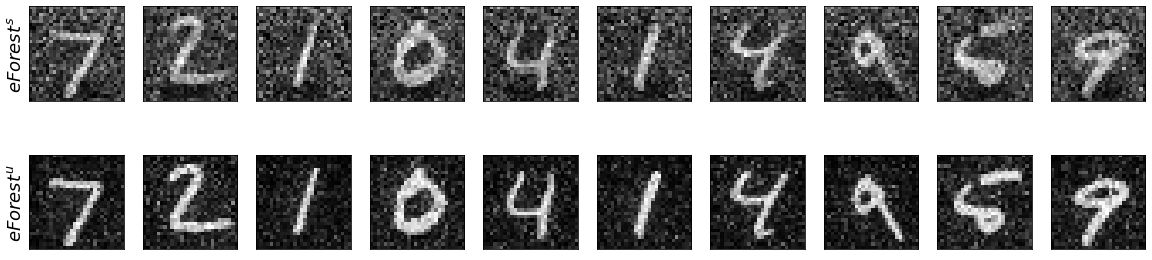

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=10, nrows=len(encoded_cifar), figsize=(20, 2.5*len(encoded_cifar)))
for j in range(len(encoded_cifar)):
  for i in range(10):
    rec = encoded_cifar[j][i]
    ax[j, i].imshow(rec.reshape(28,28),cmap='gray')
    ax[j,i].get_xaxis().set_ticks([])
    ax[j,i].get_yaxis().set_ticks([])
  s = "s" if params["supervised"][j] else "u"
  ax[j,0].set_ylabel(f"$eForest^{{{s}}}$",fontsize=18)

# Train on MNIST predict on Omniglot

In [0]:
from PIL import Image
import cv2
def omniglot_test(test_size):
  output = np.empty((test_size,105,105,4))
  result = np.empty((test_size,32,32))
  for i in range(test_size):
    output[i,:,:,:] = np.array(Image.open(f'{i}.png'))[:,:,:]
  output = np.mean(output[:,:,:,:3],axis=3)
  for i in range(test_size):
    result[i,:,:] = cv2.resize(output[i],(32,32))
  final_result = np.empty((test_size,32,32,3))
  final_result[:,:,:,0] = result[:,:,:]
  final_result[:,:,:,1] = result[:,:,:]
  final_result[:,:,:,2] = result[:,:,:]
  return final_result

In [0]:
from keras.datasets import mnist

(x_train, y_train_mnist), (x_test, y_test_mnist) = mnist.load_data()
x_train_mnist = x_train.reshape((x_train.shape[0], -1))
x_test_mnist = x_test.reshape((x_test.shape[0], -1))
print("[mnist] x_train.shape={}, y_train.shape={}".format(x_train_mnist.shape, y_train_mnist.shape))
print("[mnist] x_test.shape={}, y_test.shape={}".format(x_test_mnist.shape, y_test_mnist.shape))
test_size = 1000
encoded_mnist = [0,0]
params = {'size':[1000,1000],'supervised':[True,False]}
test = cifar_to_mnist(omniglot_test(test_size)).reshape(test_size,28*28)
for i in range(2):
  #supervised
  size = params['size'][i]
  supervised = params['supervised'][i]
  print("========================================================================")
  print(f"Autoencoder by forest with n_estimators:{size} and "+"un"*(1-int(supervised))+"supervised learning")
  encoder_mnist = AutoEncoderRF(size=size,supervised=supervised)
  if supervised:
    encoder_mnist.fit(x_train_mnist,y_train_mnist)
  else:
    encoder_mnist.fit(x_train_mnist)
  encoded_mnist[i] = encoder_mnist.predict(test)
  mse_ = mse(test.reshape(test_size,1,28,28),encoded_mnist[i][:test_size].reshape(test_size,1,28,28))
  encoded_mnist[i] = encoded_mnist[i][:10]
  print(f"MSE:{mse_}")

[mnist] x_train.shape=(60000, 784), y_train.shape=(60000,)
[mnist] x_test.shape=(10000, 784), y_test.shape=(10000,)
Autoencoder by forest with n_estimators:1000 and supervised learning



MSE:1173.5294189453125
Autoencoder by forest with n_estimators:1000 and unsupervised learning



MSE:103.89555358886719


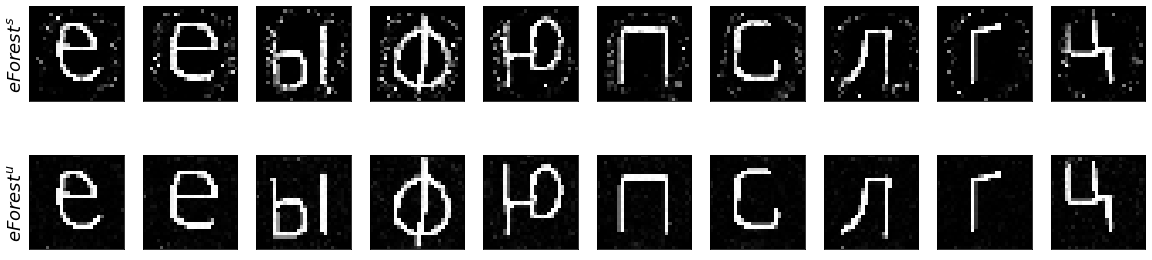

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=10, nrows=len(encoded_mnist), figsize=(20, 2.5*len(encoded_mnist)))
for j in range(len(encoded_mnist)):
  for i in range(10):
    rec = encoded_mnist[j][i]
    ax[j, i].imshow(rec.reshape(28,28),cmap='gray')
    ax[j,i].get_xaxis().set_ticks([])
    ax[j,i].get_yaxis().set_ticks([])
  s = "s" if params["supervised"][j] else "u"
  ax[j,0].set_ylabel(f"$eForest^{{{s}}}$",fontsize=18)

# Train on CIFAR-10 predict on Omniglot

In [7]:
from keras.datasets import cifar10,mnist

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_cifar = x_train.reshape((x_train.shape[0], -1, 3))
x_test_cifar = x_test.reshape((x_test.shape[0], -1, 3))
y_train_cifar = y_train.reshape(-1)
y_test_cifar = y_test.reshape(-1)
print("[cifar] x_train.shape={}, y_train.shape={}".format(x_train_cifar.shape, y_train_cifar.shape))
print("[cifar] x_test.shape={}, y_test.shape={}".format(x_test_cifar.shape, y_test_cifar.shape))

test_size=1000
encoded_cifar = [0,0]
params = {'size':[1000,1000],'supervised':[True,False]}
test = omniglot_test(test_size).reshape(test_size,32*32*3)
for i in range(2):
  #supervised
  size = params['size'][i]
  supervised = params['supervised'][i]
  print("========================================================================")
  print(f"Autoencoder by forest with n_estimators:{size} and "+"un"*(1-int(supervised))+"supervised learning")
  if supervised:

    encoder_cifar = AutoEncoderRF(size=size,supervised=supervised)
    encoder_cifar.fit(x_train_cifar.reshape(x_train_cifar.shape[0],32*32*3),y_train_cifar)
    encoded_cifar[i] = encoder_cifar.predict(test[:test_size])
  else:
    encoder_cifar = AutoEncoderRF(size=size,supervised=supervised)
    encoder_cifar.fit(x_train_cifar.reshape(x_train_cifar.shape[0],32*32*3))
    encoded_cifar[i] = encoder_cifar.predict(test[:test_size])
    
  encoded_cifar[i] = cifar_to_mnist(encoded_cifar[i])
  mse_ = mse(cifar_to_mnist(test)[:test_size].reshape(test_size,1,28,28),encoded_cifar[i][:test_size].reshape(test_size,1,28,28))
  encoded_cifar[i] = encoded_cifar[i][:10]
  print(f"MSE:{mse_}")

[cifar] x_train.shape=(50000, 1024, 3), y_train.shape=(50000,)
[cifar] x_test.shape=(10000, 1024, 3), y_test.shape=(10000,)
Autoencoder by forest with n_estimators:1000 and supervised learning



MSE:4357.18359375
Autoencoder by forest with n_estimators:1000 and unsupervised learning



MSE:1671.2288818359375


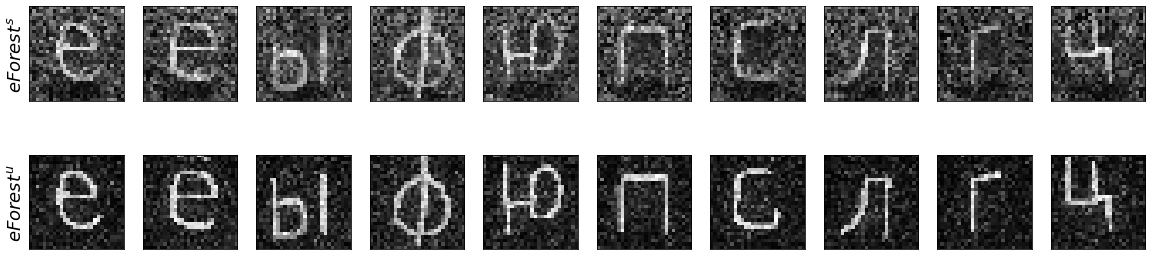

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=10, nrows=len(encoded_cifar), figsize=(20, 2.5*len(encoded_cifar)))
for j in range(len(encoded_cifar)):
  for i in range(10):
    rec = encoded_cifar[j][i]
    ax[j, i].imshow(rec.reshape(28,28),cmap='gray')
    ax[j,i].get_xaxis().set_ticks([])
    ax[j,i].get_yaxis().set_ticks([])
  s = "s" if params["supervised"][j] else "u"
  ax[j,0].set_ylabel(f"$eForest^{{{s}}}$",fontsize=18)